In [1]:
!pip install -U efficientnet

In [2]:
from keras import applications
from keras import callbacks
from keras.models import Sequential

In [3]:
import efficientnet.keras as efn

model = efn.EfficientNetB7(weights='imagenet')

268317848/268317848 [==============================] - 8s 0us/step


In [5]:
#importing all necessary packages

import cv2
import pandas as pd #pip install pandas
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers

In [9]:
# Get the current working directory
base_dir = os.getcwd()

# Specify the relative paths from the base directory
train_dir = os.path.join(base_dir, "archive", "Emergency_Vehicles", "train")
test_dir = os.path.join(base_dir, "archive", "Emergency_Vehicles", "test")
train_csv_path = os.path.join(base_dir, "archive", "Emergency_Vehicles", "train.csv")


# Load the train CSV file into a pandas DataFrame
train_df = pd.read_csv(train_csv_path)

# train_dir = "C:/Users/coolc/PycharmProjects/emergency-vehicle-classification/archive/Emergency_Vehicles/train"
# test_dir = "C:/Users/coolc/PycharmProjects/emergency-vehicle-classification/archive/Emergency_Vehicles/test"
# train_df = pd.read_csv("C:/Users/coolc/PycharmProjects/emergency-vehicle-classification/archive/Emergency_Vehicles/train.csv")
train_df.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


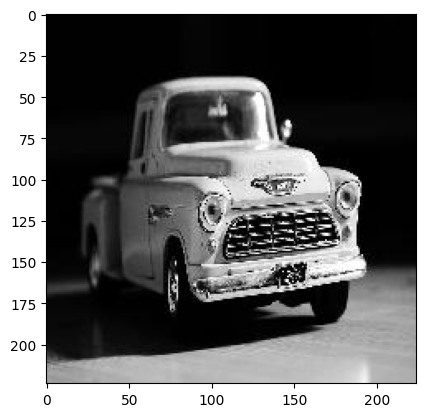

In [12]:
im = cv2.imread(os.path.join(train_dir,"1002.jpg"))
plt.imshow(im)

In [13]:
eff_net = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

258434480/258434480 [==============================] - 10s 0us/step


In [15]:
from keras.preprocessing.image import ImageDataGenerator

In [16]:
datagen=ImageDataGenerator(rescale=1./255)
batch_size=150

In [17]:
train_df.emergency_or_not=train_df.emergency_or_not.astype(str)

In [18]:
train_generator=datagen.flow_from_dataframe(dataframe=train_df[:1150],directory=train_dir,x_col='image_names',
                                            y_col='emergency_or_not',class_mode='binary',batch_size=batch_size,
                                            target_size=(32,32))


validation_generator=datagen.flow_from_dataframe(dataframe=train_df[1151:],directory=train_dir,x_col='image_names',
                                                y_col='emergency_or_not',class_mode='binary',batch_size=50,
                                                target_size=(32,32))

Found 1150 validated image filenames belonging to 2 classes.
Found 495 validated image filenames belonging to 2 classes.


In [19]:
from keras.layers import Dense
from keras.optimizers import Adam

efficient_net = efn.EfficientNetB7(
    weights='imagenet',
    input_shape=(32,32,3),
    include_top=False,
    pooling='max'
)

model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 120, activation='relu'))
model.add(Dense(units = 120, activation = 'relu'))
model.add(Dense(units = 1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b7 (Functional  (None, 2560)             64097680  
 )                                                               
                                                                 
 dense (Dense)               (None, 120)               307320    
                                                                 
 dense_1 (Dense)             (None, 120)               14520     
                                                                 
 dense_2 (Dense)             (None, 1)                 121       
                                                                 
Total params: 64,419,641
Trainable params: 64,108,921
Non-trainable params: 310,720
_________________________________________________________________


In [20]:
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

c:\users\coolc\appdata\local\programs\python\python38\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
%%time
# Train model
history = model.fit_generator(
    train_generator,
    epochs = 50,
    steps_per_epoch = 15,
    validation_data = validation_generator,
    validation_steps = 7
)

<timed exec>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
 2/15 [===>..........................] - ETA: 1:12 - loss: 0.7588 - accuracy: 0.3967

KeyboardInterrupt: 

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [ ]:
test_df = pd.read_csv('../input/emergency-vehicles-identification/Emergency_Vehicles/test.csv')

test_datagen = ImageDataGenerator(
    rescale=1/255
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = test_dir,
    x_col="image_names",
    target_size=(32,32),
    batch_size=1,
    shuffle=False,
    class_mode=None
)

In [ ]:
preds = model.predict_generator(
    test_generator,
    steps=len(test_generator.filenames)
)

In [ ]:
image_ids = [name.split('/')[-1] for name in test_generator.filenames]
predictions = preds.flatten()
data = {'image_names': image_ids, 'emergency_or_not':predictions}
submission = pd.DataFrame(data)
print(submission.head())

In [ ]:
submission['emergency_or_not'] = submission['emergency_or_not'].apply(lambda x: 1 if x > 0.75 else 0)

In [ ]:
submission.to_csv('submission_effnet.csv',index=False)